In [1]:
import re
import pandas as pd
from datetime import datetime
import torch
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import openpyxl

/Users/sadettin/Pythons/bertopic/bertopic_env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
tweets = pd.read_csv("tidy_mastodon.csv", encoding='utf-8')
#tweets_pos= tweets[tweets["sentr_durum"] == "positive"]
#tweets_pos
tweets

,id,tarih,username,text,uri,url,created_at,sensitive,language,reblogs_count,...,pos,neu,neg,but_count,durum,element_id,word_count,sd,ave_sentiment,sentr_durum
0,113749957543848103,2024-12-31,byteseu,Will Smith eating spaghetti and other weird AI...,https://pubeurope.com/users/byteseu/statuses/1...,https://pubeurope.com/@byteseu/113749957541937529,2024-12-31T23:10:08Z,True,en,2,...,0.000,0.936,0.064,0,negative,1,27,NaN,-0.048113,negative
1,113749751811493653,2024-12-31,europesays,https://www.europesays.com/1730937/ The year i...,https://pubeurope.com/users/europesays/statuse...,https://pubeurope.com/@europesays/113749751640...,2024-12-31T22:17:46Z,True,en,1,...,0.154,0.846,0.000,0,positive,2,20,NaN,0.111803,positive
2,113749336325704088,2024-12-31,byteseu,Transforming Renal Care with Dr. Waheedu Zzama...,https://pubeurope.com/users/byteseu/statuses/1...,https://pubeurope.com/@byteseu/113749336166588697,2024-12-31T20:32:06Z,True,en,2,...,0.353,0.647,0.000,0,positive,3,19,0.009685,0.295523,positive
3,113749281197380271,2024-12-31,wultyc,Every time I use an AI tool I greet it in the ...,https://mastodon.social/users/wultyc/statuses/...,https://mastodon.social/@wultyc/11374928119738...,2024-12-31T20:18:07Z,False,en,0,...,0.101,0.840,0.059,0,positive,4,43,0.274604,0.011470,positive
4,113749221328288980,2024-12-31,europesays,https://www.europesays.com/1730659/ Mozilla En...,https://pubeurope.com/users/europesays/statuse...,https://pubeurope.com/@europesays/113749221158...,2024-12-31T20:02:51Z,True,en,2,...,0.000,1.000,0.000,0,neutral,5,14,NaN,0.000000,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25730,109613570411608947,2023-01-01,bron,Meet Zara... my Artificial Intelligence Teachi...,https://aus.social/users/bron/statuses/1096135...,https://aus.social/@bron/109613569913005762,2023-01-01T10:52:21Z,False,en,2,...,0.134,0.850,0.015,1,positive,29422,113,0.147100,0.248255,positive
25731,109613310407597716,2023-01-01,REEL,Completely missed this at the time but really ...,https://ravenation.club/users/REEL/statuses/10...,https://ravenation.club/@REEL/109613310148604200,2023-01-01T09:46:18Z,False,en,1,...,0.290,0.581,0.129,1,positive,29423,43,0.296326,-0.157813,negative
25732,109613150369495260,2023-01-01,RecursiveNeuron,📒Plain python implementations of basic machine...,https://techhub.social/users/RecursiveNeuron/s...,https://techhub.social/@RecursiveNeuron/109613...,2023-01-01T09:05:37Z,False,en,4,...,0.000,1.000,0.000,0,neutral,29424,32,NaN,0.309359,positive
25733,109612874273452567,2023-01-01,RecursiveNeuron,Python (programming) generated using midjourne...,https://techhub.social/users/RecursiveNeuron/s...,https://techhub.social/@RecursiveNeuron/109612...,2023-01-01T07:55:09Z,False,en,1,...,0.000,1.000,0.000,0,neutral,29425,14,NaN,0.000000,neutral


In [4]:
# Filter negative
tweets = tweets.dropna(subset=['text'])
tweets.text = tweets.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
tweets.text = tweets.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
tweets.text = tweets.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
tweets = tweets.loc[tweets.text != "", :]

#timestamps = uk_us.date1.to_list()
timestamps = tweets.tarih.to_list()
tweets2 = tweets.text.to_list()


In [5]:
# Prepare embeddings
custom_stopwords = ["generative","artificial","intelligence","ai","artificialintelligence","pelvis","naked"]
all_stopwords = list(ENGLISH_STOP_WORDS) + custom_stopwords

# Initialize the CountVectorizer with the combined stopwords
vectorizer_model = CountVectorizer(stop_words=all_stopwords)
sentence_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = sentence_model.encode(tweets2, show_progress_bar=False)


In [12]:
# Train BERTopic
topic_model = BERTopic(min_topic_size=100,
                        vectorizer_model=vectorizer_model,
                       verbose= True).fit(tweets2, embeddings)

2025-01-14 21:48:13,569 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-14 21:48:17,732 - BERTopic - Dimensionality - Completed ✓
2025-01-14 21:48:17,732 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been us

In [21]:
topic_model.get_topic(10)

[('deepfake', 0.049273289582821705),
 ('sigma', 0.034591467599083776),
 ('deepfakes', 0.02728444160213219),
 ('male', 0.024656974817124554),
 ('porn', 0.02143762415767933),
 ('voice', 0.02125210988342141),
 ('males', 0.02043401004652519),
 ('scam', 0.01886807323586388),
 ('video', 0.01816374716193594),
 ('women', 0.016495421941575467)]

In [31]:
freq=topic_model.get_topic_info()
# Save as XLSX
freq.to_excel('mastodon_topic_frequency.xlsx', index=False)
freq

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,-1,10009,-1_chatgpt_technology_tech_art,-1_chatgpt_technology_tech_art,"[chatgpt, technology, tech, art, new, aiart, o...",[free wallpapers for you to use also uploaded ...
1,0,1269,0_published_nvidia_news_finance,Tech News,"[published, nvidia, news, finance, tech, stock...",[tech startup surge sees million investment in...
2,1,844,1_healthcare_health_medical_cancer,Healthcare,"[healthcare, health, medical, cancer, medicine...",[email list amp lemmy a bit behind on this new...
3,2,844,2_jobs_workers_business_work,Business & Jobs,"[jobs, workers, business, work, job, technolog...","[artificialintelligence jobs automation, artif..."
4,3,816,3_people_humans_human_humanity,3_people_humans_human_humanity,"[people, humans, human, humanity, think, just,...",[godfather of ai shortens odds of the technolo...
5,4,725,4_energy_climate_nuclear_power,Energy & Climate,"[energy, climate, nuclear, power, environment,...",[french ai summit to focus on environmental im...
6,5,724,5_chatgpt_gpt_chatbot_openai,OpenAI & ChatGPT,"[chatgpt, gpt, chatbot, openai, die, der, ki, ...","[chatgpt artificialintelligence, ai chatgpt, a..."
7,6,563,6_portrait_seeds_beauty_vibrant,Energy & Climate,"[portrait, seeds, beauty, vibrant, portraits, ...",[interconnected stories a diverse portraitin t...
8,7,503,7_fediart_midjourneyai_midjourneyart_midjourney,Generative Art & Midjourney,"[fediart, midjourneyai, midjourneyart, midjour...",[like so aiart midjourneyart midjourneyai arti...
9,8,453,8_thunkdeep_thunkspiracy_thinktanktheorium_dig...,8_thunkdeep_thunkspiracy_thinktanktheorium_dig...,"[thunkdeep, thunkspiracy, thinktanktheorium, d...",[cosmic mind trip rockets stars and psychedeli...


In [25]:
#changing labels
topic_model.set_topic_labels({0:"Tech News",
                             1:"Healthcare",
                             2:"Business & Jobs",
                             4:"Energy & Climate",
                             5:"OpenAI & ChatGPT",
                             6:"Energy & Climate",
                             7:"Generative Art & Midjourney",
                             10:"Deepfakes & Porn",
                             11:"Writing & Journalism",
                             13:"Hollywood & Actors",
                             16:"EU AI Acts",
                             17:"Cybersecurity",
                             18:"Smartphone Features",
                             19:"Election Disinformation",
                             21:"Photos & Images",
                             22:"Copyrights",
                             23:"Meta AI",
                             24:"ML & Data Science",
                             25:"Art & Creativity",
                             26:"Education & Learning ",
                             27:"Bias & Discrimination",
                             29:"Digital Marketing",
                             32:"Court & Law",
                             34:"Search & Internet",
                             36:"AI Ethics",
                             38:"Coding & Programming",
                             40:"Robotics",
                             42:"Gaming",
                             48:"Government & Regulation"
                             })

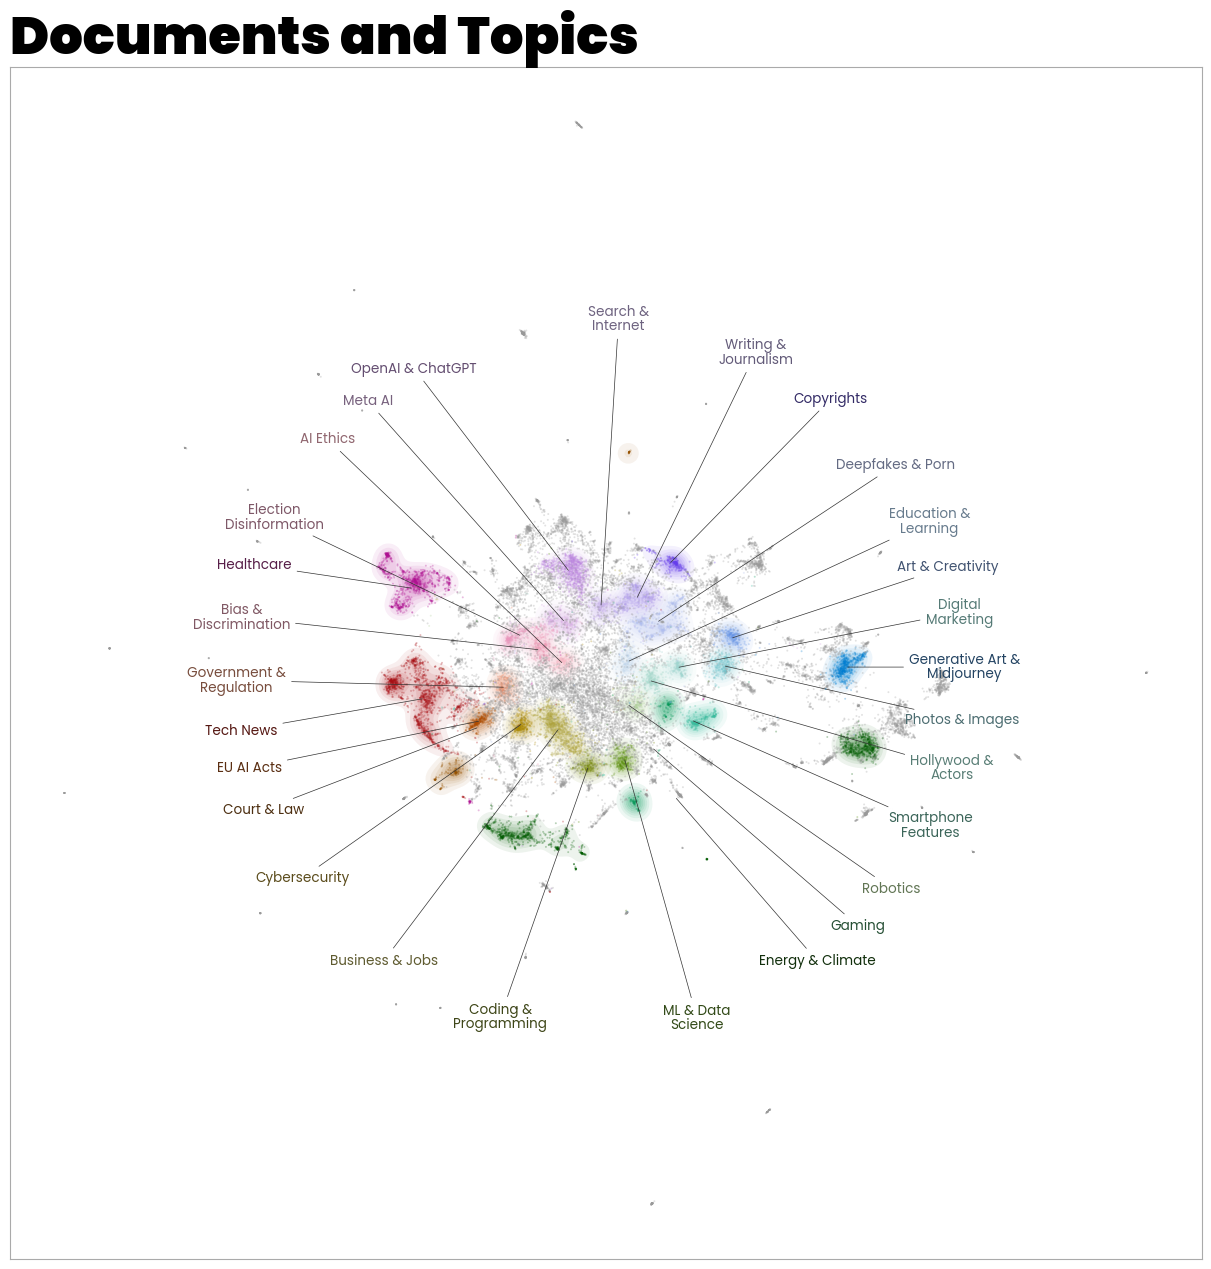

In [33]:
# with the original embeddings
# with the original embeddings
fig1=topic_model.visualize_document_datamap(tweets2, embeddings=embeddings,
                                            custom_labels =True,
                                            font_family="Poppins",
                                            max_font_size=40,
                                            min_font_size=10,
                                            point_size=2,
                topics =[0,1,2,4,5,6,7,10,11,13,16,17,18,19,21,22,23,24,25,26,27,29,32,34,36,38,40,42,48])

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


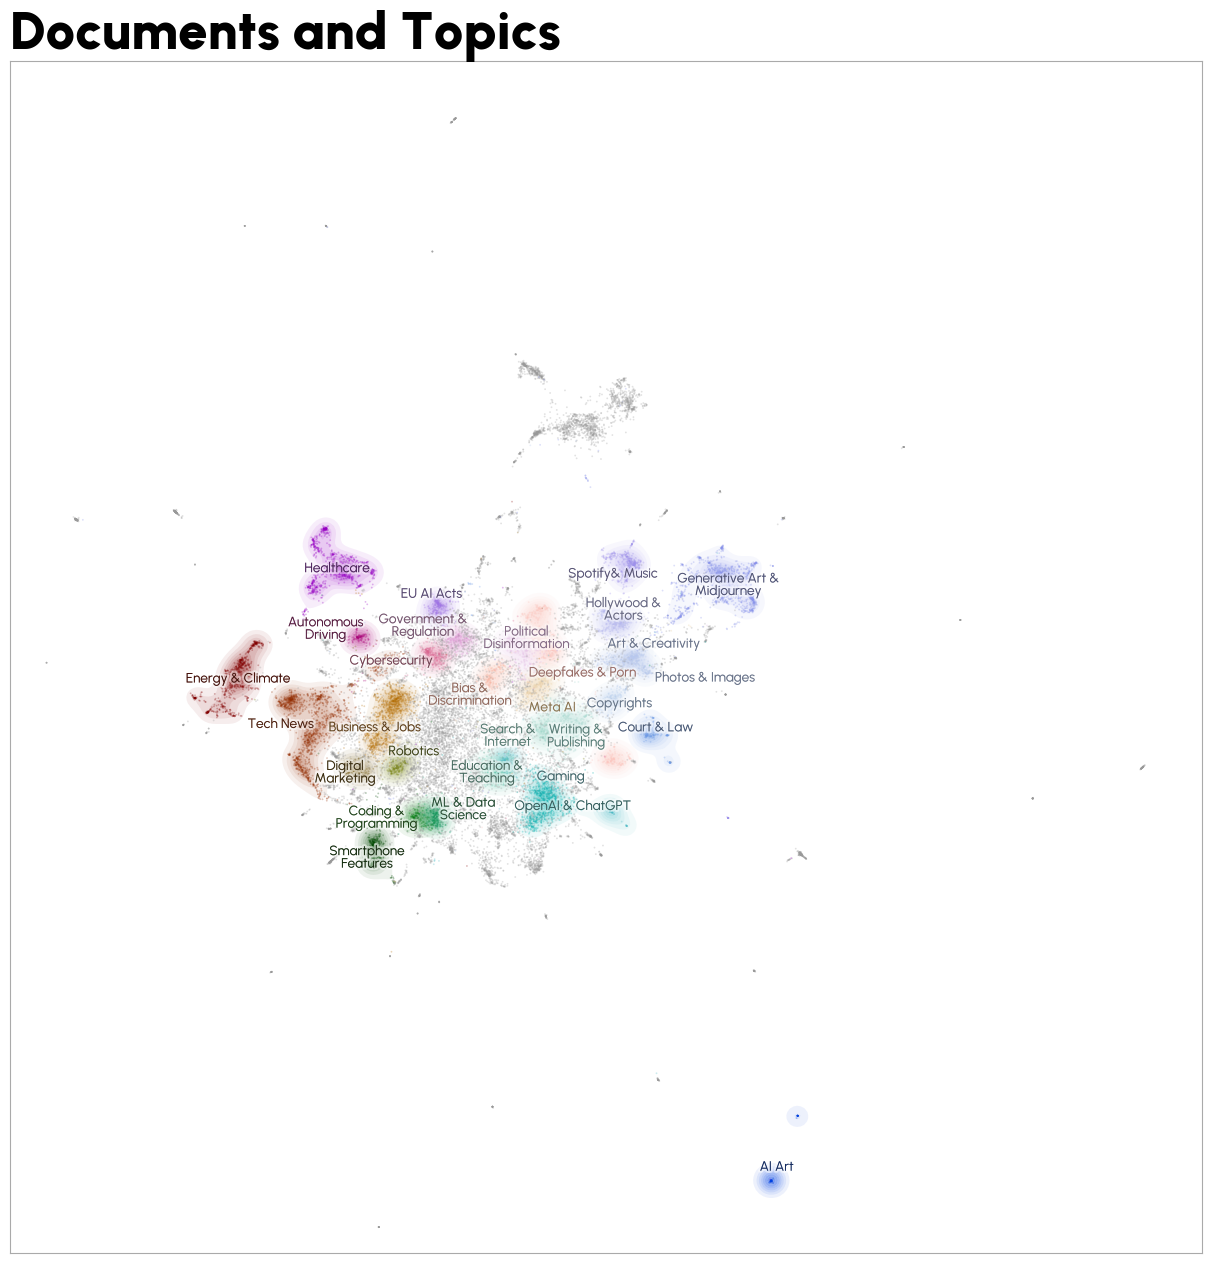

In [33]:
# with the original embeddings
fig2=topic_model.visualize_document_datamap(tweets2, embeddings=embeddings,
                                            label_over_points=True,
                                            custom_labels =True,
                                            font_family="Urbanist",
                                            max_font_size=30,
                                            min_font_size=10,
                                           topics =[1,2,3,4,5,6,8,9,11,13,16,17,18,19,21,22,23,24,25,26,27,28,29,34,35,36,39,41,44,47])

In [35]:
fig1.savefig("file_mast.pdf")
fig1.savefig("file_mast.svg")

In [35]:
?topic_model.visualize_document_datamap

Signature:
topic_model.visualize_document_datamap(
    docs: List[str],
    topics: List[int] = None,
    embeddings: numpy.ndarray = None,
    reduced_embeddings: numpy.ndarray = None,
    custom_labels: Union[bool, str] = False,
    title: str = 'Documents and Topics',
    sub_title: Optional[str] = None,
    width: int = 1200,
    height: int = 1200,
    **datamap_kwds,
)
Docstring:
Visualize documents and their topics in 2D as a static plot for publication using
DataMapPlot. This works best if there are between 5 and 60 topics. It is therefore best
to use a sufficiently large `min_topic_size` or set `nr_topics` when building the model.

Arguments:
    topic_model:  A fitted BERTopic instance.
    docs: The documents you used when calling either `fit` or `fit_transform`
    embeddings:  The embeddings of all documents in `docs`.
    reduced_embeddings:  The 2D reduced embeddings of all documents in `docs`.
    custom_labels:  If bool, whether to use custom topic labels that were def